In [1]:
import os
import sys
import glob
import cv2
import time

import pandas as pd
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.utils.model_zoo import load_url as load_state_dict_from_url
import torchvision
import torchvision.transforms as transforms

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

import albumentations
from albumentations import torch as at

In [4]:
import warnings
warnings.filterwarnings('ignore')

PATH = os.path.join('..', 'input')

if torch.cuda.is_available():
    print('Cuda is available. GPU MODE!')
    device = 'cuda'
else:
    print('Cuda is not available. CPU MODE!')
    device = 'cpu'

Cuda is not available. CPU MODE!


In [5]:
train = pd.read_csv(os.path.join(PATH, 'train.csv'))
test = pd.read_csv(os.path.join(PATH, 'test.csv'))

In [6]:
def prepare_labels(y):
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(y)

    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

    y = onehot_encoded
    return y, label_encoder

y, le = prepare_labels(train['diagnosis'].values)

In [177]:
class DRDataset(Dataset):
    
    def __init__(self, df, datatype='train', transform=None, y=None):
        
        # TODO: FIX
        self.df = df
        self.datatype = datatype
        self.image_files_list = [f'../input/{self.datatype}_images/{i}.png' for i in df['id_code'].values]
        
        if self.datatype == 'train':
            self.labels = y
        else:
            self.labels = np.zeros((df.shape[0], 5))
        
        self.transform = transform
        
    def __len__(self):
        
        return len(self.image_files_list)
    
    def __getitem__(self, idx):
        scale = 512
        img_name = self.image_files_list[idx]
        
        img = cv2.imread(img_name)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (scale, scale))
        img = cv2.addWeighted(img, 4, cv2.GaussianBlur(img, (0, 0), 10), -4, 128)

        image = self.transform(image=img)
        image = image['image']
        
        img_name_short = img_name.split('.')[0]

        label = self.labels[idx]
        if self.datatype == 'test':
            return image, label, img_name
        else:
            return image, label

In [178]:
train_transforms = albumentations.Compose([
    albumentations.Resize(256, 256),
#     albumentations.MedianBlur(),
#     albumentations.ChannelShuffle(),
#     albumentations.RGBShift(),
#     albumentations.ToGray(),
#     albumentations.CLAHE(),
#     albumentations.HorizontalFlip(),
#     albumentations.ShiftScaleRotate(rotate_limit=[0, 1], scale_limit=[0.10, 0.10]),
#     albumentations.Normalize(),
#     at.ToTensor()
    ])

test_transforms = albumentations.Compose([
    albumentations.Resize(256, 256),
#     albumentations.Normalize(),
    at.ToTensor()
    ])

In [179]:
train_dataset = DRDataset(df=train, datatype='train', transform=train_transforms, y=y)
test_dataset = DRDataset(df=test, datatype='test', transform=test_transforms)

tr, val = train_test_split(train.diagnosis, stratify=train.diagnosis, test_size=0.1)

train_sampler = SubsetRandomSampler(list(tr.index))
valid_sampler = SubsetRandomSampler(list(val.index))

batch_size = 8
num_workers = 0

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)

ValueError: axes don't match array

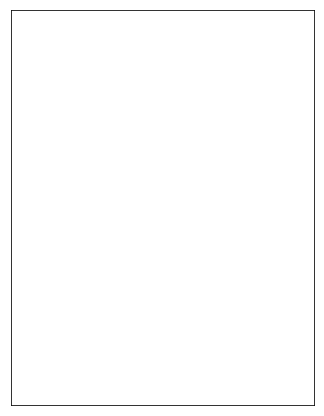

In [180]:
fig = plt.figure(figsize=(25, 16))

for (data, target) in train_loader:

    for i in range(batch_size):
        ax = fig.add_subplot(2, 4, i + 1, xticks=[], yticks=[])
        img = data[i].numpy().transpose((1, 2, 0))
        plt.imshow(img)
        ax.set_title(f'Label: {target[i]}')

    break